#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>


## Подготовка

In [1]:
#pip install statsmodels --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Подгружаем данные и проверяем нет ли в них очевидных ошибок (отрицательные значения, выбросы, пропуски).

In [3]:
data = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])

data.sort_index(inplace = True)

print('Общая информация о подгруженных данных')
print()
print(data.info())
print()
print('Первые строки датасета')
print()
print(data.head())
print()
#посмотрим бегло на данные, нет ли очевидных ошибок, отрицательных значений, или выбивающихся на пару порядков..
print('Уникальные значения заказов такси за 10-ти минутный период')
print(data['num_orders'].unique())


Общая информация о подгруженных данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Первые строки датасета

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

Уникальные значения заказов такси за 10-ти минутный период
[  9  14  28  20  32  21   7   5  17  12  19  25  22   8   6   4  10  13
   2   3   0   1  11  15  16  23  18  33  24  26  30  38  34  42  31  27
  36  29  35  56  37  40  39  45  49  58  68  43  53  44  41  52  46  57
  47  64  61  50  48  55  62  54  71  78 119  99  51  60  87  90  94  82
  80  91  76  66  65  98  81  95  67]


Данные прочитаны, проведена базовая подготовка (обработан формат даты, добавлен в индекс), строки просортированы по возрастающей, данные проверены на выбросы.

В итоге осталось почти 4,5 тыс значений, данные есть с марта по август 2018 года. Первый вывод - для полноценной модели, которая бы учитывала сезонность данных не достаточно, в идеале - иметь хотя бы несколько лет..

Выполним ресемплирование по одному часу для построения модели прогнозов:

In [4]:
# данные даны за 10-ти минутки, поэтому с учетом требований прогноза на час вперед, проведем ресемплинг
data = data.resample('1H').sum()
print()
print('Проверим количество строк в новом датасете')
print()
print(data.info())
#строк стало в 6 раз меньше, все сработало как полагается


Проверим количество строк в новом датасете

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


Данные прочитаны, проведена базовая подготовка (обработан формат даты, добавлен в индекс), строки просортированы по возрастающей, данные проведены на выбросы, проведен ресемплинг. Проверили методом .info() новый датасет, данные готовы.

## Анализ

Цель данного раздела в аналитическом и визуальном знакомстве с данными, выявлении в них закономерностей, что поможет:
1. Лучше разобраться с чем именно работаем, как подступиться к задаче.
2. Выявить тенденции в количестве заказов во времени.
3. Установить возможные периоды, данные за который помогут в построении модели прогноза. 
4. Оценить возможное качество работы модели и периодов времени, в которые мы будем ожидать адекватной ее работы.

Общее описание данных

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

Сколь 0-вых значений: 1

Количество заказов в час за предоставленный период


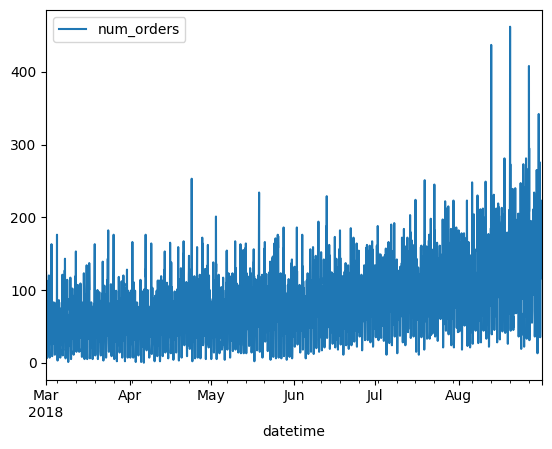

Диаграмма ящик с усами


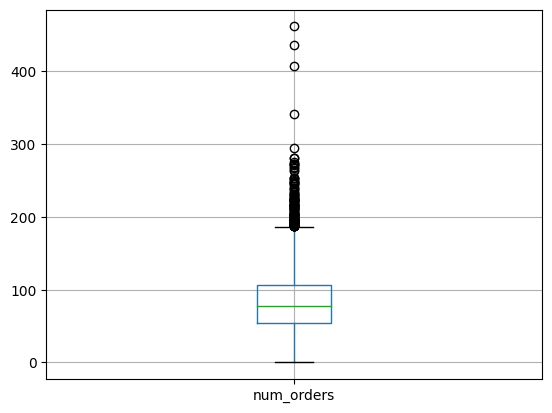

In [5]:
#Посмотрим для начала распределение полученных значений
print('Общее описание данных')
print()
print(data.describe())
print()
print('Сколь 0-вых значений:', data[data['num_orders'] == 0]['num_orders'].count())
print()
print('Количество заказов в час за предоставленный период')
data.plot()
plt.show()
print('Диаграмма ящик с усами')
data.boxplot()
plt.show()

Медианное количество заказов в час составляет 78 штук, среднее - чуть выше, 84.4, следовательно распределение скошено вправо. Максимум зарегистрировано 462 заказа за час, и всего один час за пол года не было ни одного заказа (может сервис не работал?). В целом наблюдаем повышающийся тренд, что может быть связано с летними отпусками. 

Построим график скользящей средней для лучшего понимания среднего количества заказов:

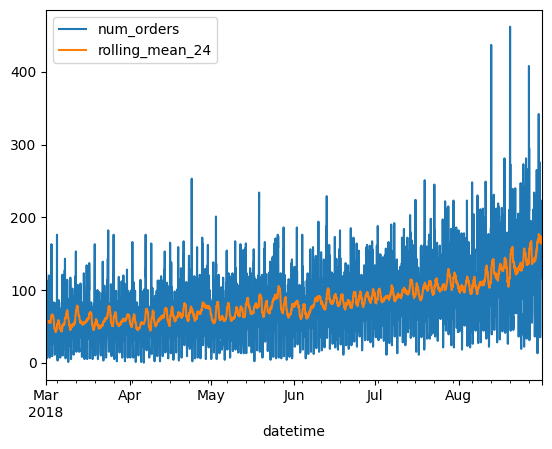

In [6]:
#Теперь построим график скользящей средней
data['rolling_mean_24'] = data.rolling(24).mean()
data.plot()
plt.show()
del data['rolling_mean_24']
#print(data.info())


Построив среднесуточное количество заказов за период в 6 месяцев, отмечаем что оно не столь существенно меняется в соседние дни. А также подтверждаем повышающийся тренд количества заказов заметно ускоряющийся в августе. 

Далее разобъем ряд методом seasonal_decompose() для выявления трендовой, сезонной и случайной составляющих:

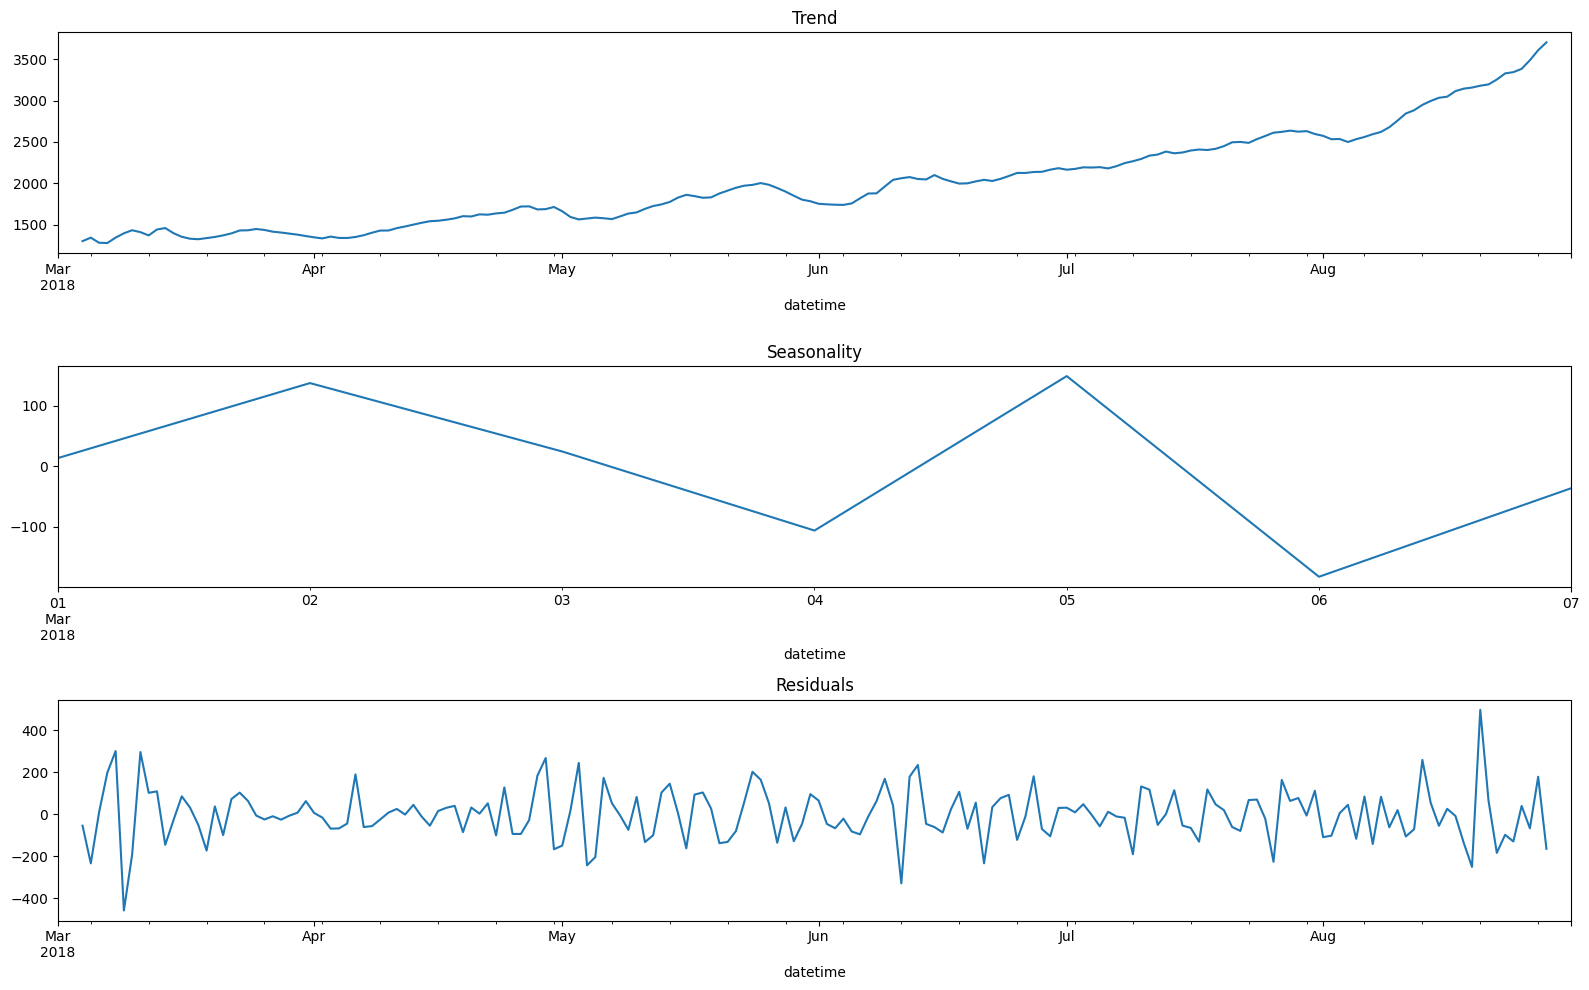

In [7]:
#Попробуем разбить ряд на тренд и сезонность, но для этого заресемплим до одного дня
data_1d = data.resample('1D').sum()
decomposed = seasonal_decompose(data_1d)


plt.figure(figsize=(16, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()


Ранее сделанные выводы подтверждаются. Важно отметить недельный период в сезонной составляющей количества заказов, что подталкивает на мысль, что период данных для модели есть смысл смотреть как минимум за последнюю неделю. Дополнительно отметим, как меняется количество заказов от времени суток. Видны достаточно ожидаемые ночные просадки, и пару всплесков активности пользователей в районе 16 и 24 часов.

## Обучение

Обучать модель будем с помощью линейной регрессии, а в качестве признаков выберем следующие: 
- данные за предыдущие периоды
- скользяющая средняя по ним

Параметры будем перебирать для поиска наиболее удачной модели:
- продолжительность временного коридора, по которому строим прогноз
- ширина окна скользяющей средней

Напишем функцию для создания описанных признаков, попробуем сначала создавать всего 1 столбец с предыдущим значением.

In [8]:
# Напишем функцию для создания признаков датасета
# попробуем сначала создавать не несколько столбцов, а всего 1, с лагом, который присвоим функции
def make_features_1(data, lag, ma_length):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_average'] = data['num_orders'].shift().rolling(ma_length).mean()
    
#проверяем
#make_features(data, 4, 4)
#print(data.head())
#работает, идем дальше

In [9]:
# начнем с базовых сценариев, прогноз по медиане и по последнему значению,
# для того чтобы было с чем сравнивать дальнейшие результаты

#1. Медианная оценка
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

#print(test.head())
median_est = [train['num_orders'].median()] * len(test)

print('RMSE медианной модели составляет:', mean_squared_error(test, median_est)**0.5)

#2. оценка по предыдущему значению
data['lag_1'] = data['num_orders'].shift()
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
data = data.drop(['lag_1'], axis = 1)

print('RMSE оценки по предыдущему значению составляет:', mean_squared_error(test['num_orders'], test['lag_1'])**0.5)

RMSE медианной модели составляет: 87.15277582981295
RMSE оценки по предыдущему значению составляет: 58.856486242815066


Есть с чем работать, базовые оценки метрики на простейших моделях получены, от оценки по предыдущему значению надо улучшить качество метрики еще на 11 (около 18%).

In [10]:
# Прогоним через цикл различные параметры модели и подберем оптимальные
top_rmse = 100
top_lag = 0
top_ma_length = 0



for lag in range(1, 170):
    for ma_length in range(1,5):
        pure_data = data.copy()
        make_features_1(pure_data, lag, ma_length)
        train, second = train_test_split(pure_data, shuffle=False, test_size=0.2)
        train = train.dropna()
        valid, test = train_test_split(second, shuffle = False, test_size = 0.5)
        
        features_train = train.drop(['num_orders'], axis = 1)
        target_train = train['num_orders']
        
        features_valid = valid.drop(['num_orders'], axis = 1)
        target_valid = valid['num_orders']
        
        features_test = test.drop(['num_orders'], axis = 1)
        target_test = test['num_orders']
        
        model = LinearRegression()
        model.fit(features_train, target_train)
        test_predictions = model.predict(features_valid)
        rmse_result = mean_squared_error(target_valid, test_predictions) ** 0.5
#        print('При параметрах lag =', lag, 'и ma_length =', ma_length)
#        print("RMSE тестовой выборки: ", rmse_result)
#        print()
        if rmse_result < top_rmse:
            top_rmse = rmse_result
            top_lag = lag
            top_ma_length = ma_length

print()
print('Лучшее значение RMSE на валидационной выборке = ', top_rmse, 'получено при параметрах смещение =', top_lag, 'и окне скользящей средней', top_ma_length)



Лучшее значение RMSE на валидационной выборке =  31.541397886519448 получено при параметрах смещение = 168 и окне скользящей средней 1


Получаем следующий результат:
- Лучшее значение RMSE на валидационной выборке =  31.54139788651945 получено при параметрах смещение = 168 и окно скользаящей среней 1

Что же, параметры подобраны, и важно что решение логически понятно: Наиболее точная оценка на час вперед - посмотреть что было в этот час неделю назад. С учетом того, как была написана функция make_features, модель в качестве признака в данный момент рассматривает только одно значение, сколько-то часов назад. Теперь попробуем создавать больше признаков (смещение в 1 час, 2, ...) и посмотрим, насколько это повысит точность модели.

In [11]:
def make_features_2(data, lag, ma_length):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for l in range(1, lag+1):
        data['lag_{}'.format(l)] = data['num_orders'].shift(l)
        
    data['rolling_average'] = data['num_orders'].shift().rolling(ma_length).mean()

In [12]:
# Прогоним через цикл различные параметры модели и подберем оптимальные
top_rmse = 100
top_lag = 0
top_ma_length = 0

for lag in range(1, 170):
    for ma_length in range(1,8):
        pure_data = data.copy()
        make_features_2(pure_data, lag, ma_length)
        train, second = train_test_split(pure_data, shuffle=False, test_size=0.2)
        valid, test = train_test_split(second, shuffle = False, test_size = 0.5)
        train = train.dropna()
        
        features_train = train.drop(['num_orders'], axis = 1)
        target_train = train['num_orders']
        
        features_valid = valid.drop(['num_orders'], axis = 1)
        target_valid = valid['num_orders']
        
        features_test = test.drop(['num_orders'], axis = 1)
        target_test = test['num_orders']
        
        model = LinearRegression()
        model.fit(features_train, target_train)
        test_predictions = model.predict(features_valid)
        rmse_result = mean_squared_error(target_valid, test_predictions) ** 0.5
#        print('При параметрах lag =', lag, 'и ma_length =', ma_length)
#        print("RMSE тестовой выборки: ", rmse_result)
#        print()
        if rmse_result < top_rmse:
            top_rmse = rmse_result
            top_lag = lag
            top_ma_length = ma_length

print()
print('Лучшее значение RMSE = ', top_rmse, 'получено при параметрах смещение =', top_lag, 'и окне скользящей средней', top_ma_length)



Лучшее значение RMSE =  28.0208971574986 получено при параметрах смещение = 169 и окне скользящей средней 5


Создавая не один признак, а набор признаков (предыдущих значений за 1, 2, 3, ... , 170 часов), перебором параметров модели мы получили следующих наилучший результат на валидационной выборке:

- Лучшее значение RMSE =  28.0208971574986 получено при параметрах смещение = 169 и окне скользящей средней 5


## Тестирование

Посмотрим теперь как модели с уже подобранными на валидационной выборке параметрами сработают на тестовой. начнем с первого способа дробавления всего одного признака о количестве заказов такси n часов назад. Оптимальные параметры были - 168, 1.


In [13]:
pure_data = data.copy()
make_features_1(pure_data, 168, 1)
train, second = train_test_split(pure_data, shuffle=False, test_size=0.2)
valid, test = train_test_split(second, shuffle = False, test_size = 0.5)
train = train.dropna()
        
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
            
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
        
model = LinearRegression()
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
rmse_result = mean_squared_error(target_test, test_predictions) ** 0.5
print('Значение метрики RMSE на тестовой выборке:', rmse_result)

Значение метрики RMSE на тестовой выборке: 37.177076636259585


Итак, результат на тестовой выборке следующий: Значение метрики RMSE на тестовой выборке: 37.177076636259585



Перейдем теперь ко второму способу добавления сразу нескольких признаков о количестве заказов в прошлом:

In [14]:
pure_data = data.copy()
make_features_2(pure_data, 169, 1)
train, second = train_test_split(pure_data, shuffle=False, test_size=0.2)
valid, test = train_test_split(second, shuffle = False, test_size = 0.5)
train = train.dropna()
        
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
            
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
        
model = LinearRegression()
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
rmse_result = mean_squared_error(target_test, test_predictions) ** 0.5
print('Значение метрики RMSE на тестовой выборке:', rmse_result)

Значение метрики RMSE на тестовой выборке: 36.7514341523831


Итак, подобрав оптимальные параметры подбора признаков (на валидационной выборке) модель линейной регрессии позволила достичь значения метркии RMSE в 37.18 при прогнозе всего по одному значению в неделю назад. Добавление 169 значений количества заказов за последнее время позволило сократить значение метрики до 36.72 (улучшение на ~ 1,5%).



## Выводы

Для решения задачи испробованы различные параметры добавления признаков для построения модели линейной регрессии:
- продолжительность временного коридора, по которому строим прогноз
- ширина окна скользяющей средней

В ходе написания функции make_features, мы проверили, насколько хуже будут результаты обучения моделей, если рассматривать только одно значение из прошлого, по сравнению с набором предыдущих значений. 

Напомним, значение метрики RMSE при прогнозе по предыдущему значению составило 58 (простейшая модель). При прогнозе по значению за неделю "до" - уже 37.18. А вот добавление всех предыдущих значений за последнюю неделю (169 параметров) позволяет еще немного снизить значение метрики, до 36.72. Улучшение хоть и всего в 1.5%, но для бизнеса пользу несет. Другой вопрос - а насколько важна скорость построения прогноза, по одному параметру она будет существенно быстрее.

Результаты подбора параметров объяснимы, люди чаще уезжают и возвращаются из отпусков в выходные, частота прилетов в течение дня схожа от недели к неделе, что мы и обнаружили в ходе анализа данных.